In [1510]:
#!g1.1
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Подготовка словаря

In [1517]:
#!g1.1
file = open('sentences.txt', 'r')
sentences = list(map(lambda line: line.strip(), file.readlines()))
file.close()

In [1518]:
#!g1.1
from collections import Counter
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
#tokenizer = nltk.tokenize.TreebankWordTokenizer()

token_counts = Counter(tokenizer.tokenize(' '.join(sentences)))

In [1519]:
#!g1.1
min_count = 1

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = []
for key, values in token_counts.items():
    if values >= min_count:
        tokens.append(key)

# Add a special tokens for unknown and empty words
BOS, EOS, UNK, PAD = '_BOS_', '_EOS_', '_UNK_', '_PAD_'
tokens = [PAD, BOS, EOS, UNK] + tokens

In [1520]:
#!g1.1
# словарь
token_to_id = {tok: i for i, tok in enumerate(tokens)}

### Dataset и Dataloader

In [1511]:
#!g1.1
from dataloader import LipReadingVideoDataset, LipReadingVideoDatasetZIP, collate_func

In [1512]:
#!g1.1
# path to dataset
trainval_data_path_zip = os.path.normpath('../data/lrs3_trainval.zip')
test_data_path_zip = os.path.normpath('../data/lrs3_test_v0.4.zip')

In [1513]:
#!g1.1
from torchvideotransforms import video_transforms

flip = video_transforms.RandomHorizontalFlip(p=0.5)
rotation = video_transforms.RandomRotation(degrees=15)

transform = video_transforms.Compose([flip, rotation])

In [1543]:
#!g1.1
batch = 4

# load trainval
trainval_ds_zip = LipReadingVideoDatasetZIP(trainval_data_path_zip, transform=transform)

N = len(trainval_ds_zip)
train_N = int(0.9*N)
val_N = N - train_N
train_ds, val_ds = torch.utils.data.random_split(trainval_ds_zip, (train_N, val_N), 
                                                 generator=torch.Generator().manual_seed(42))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch, shuffle=True, collate_fn=collate_func)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch, shuffle=True, collate_fn=collate_func)

# load test
test_ds = LipReadingVideoDatasetZIP(test_data_path_zip, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch, shuffle=True, collate_fn=collate_func)

### Network

In [1521]:
#!g1.1
from network import LipReadinNN
from model_train_functions import train_model, test_model

In [1522]:
#!g1.1
lip_reading_nn = LipReadinNN(token_to_id)
opt = torch.optim.Adam(lip_reading_nn.parameters(), lr=0.001)

In [ ]:
#!g1.1
# load model

#PATH = 'model.pt'
#lip_reading_nn = LipReadinNN(token_to_id)
#lip_reading_nn.load_state_dict(torch.load(PATH)) ???
#lip_reading_nn.to(device)

|

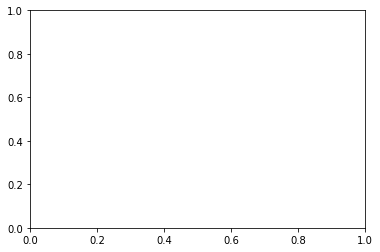

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [1545]:
#!g1.1
device = torch.device('cpu')# if not torch.cuda.is_available() else 'cuda')
epoch = 3

for e in range(epoch):
    train_loss, val_loss = train_model(model=lip_reading_nn, 
                                   train_dataloader=train_dl, 
                                   val_dataloader=val_dl, 
                                   optimizer=opt, 
                                   device=device)
    
    test_loss = test_model(model=lip_reading_nn, 
                           test_dataloader=test_dl, 
                           device=device)
    
    print(f'EPOCH {e} is ended')
    print(f'last mean loss on train: \t{train_loss[-1]}')
    print(f'last mean loss on val: \t{val_loss[-1]}')
    print(f'mean loss on test: \t{np.array(test_loss).mean()}')

In [ ]:
#!g1.1
li

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [1540]:
#!g1.1
for i, (vframes_batch, list_of_tokens) in enumerate(train_dl):
    print(vframes_batch.shape)
    if i >= 0:
        break

torch.Size([4, 5, 128, 3, 224, 224])


In [1541]:
#!g1.1
lip_reading_nn.train(False)

vframes_batch = vframes_batch.to(device)
output = lip_reading_nn(vframes_batch)

In [1542]:
#!g1.1
output

[['_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_'],
 ['_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_'],
 ['_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_',
  '_PAD_'],
 ['_PAD

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
#!g1.1
